In [1]:
library(igraph)
library(tidygraph)
library(tidyverse)
library(cowplot)

fam <- read_delim('~/data/genesis/genesis_2019.fam', delim = ' ', col_names = FALSE, col_types = 'iciiii')


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘tidygraph’

The following object is masked from ‘package:igraph’:

    groups

The following object is masked from ‘package:stats’:

    filter

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks tidygraph::filter(), stats::filter()
✖ purrr::flatten()       masks jsonlite::flatten()
✖ dplyr::groups()        masks tidygraph::groups(), igr

# SF1

In [2]:
evs <- read_tsv('../results/conventional_gwas/genesis_2019.eigenvec')

options(repr.plot.width=7.4, repr.plot.height=7.5)
pc1_2 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC2, PC1, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

pc3_4 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC4, PC3, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

pc5_6 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC6, PC5, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

pc7_8 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC8, PC7, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

sf1 <- plot_grid(pc1_2, pc3_4, pc5_6, pc7_8, labels = c('A','B','C','D'))

Parsed with column specification:
cols(
  .default = col_double(),
  IID = col_character()
)
See spec(...) for full column specifications.


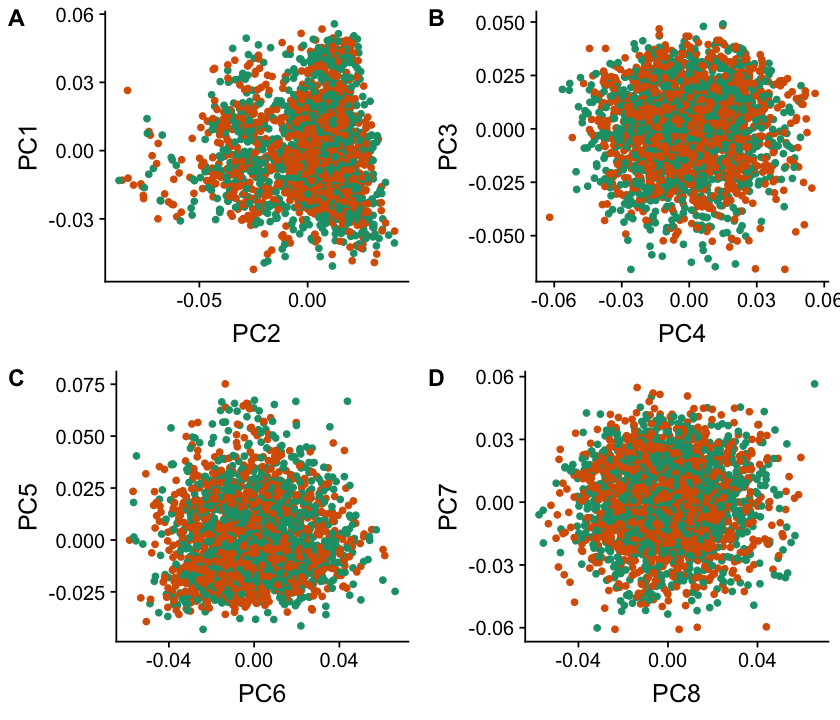

In [3]:
options(repr.plot.width=7, repr.plot.height=6)
sf1
ggsave('figures/sfigure_1.pdf', sf1, width=7, height=6)

# SF2

In [4]:
hgnc <- read_tsv('../results/preprocessing/non_alt_loci_set.txt', col_types = cols(.default = "c")) %>%
    select(symbol, ensembl_gene_id)
ppi <- read_tsv('../results/preprocessing/hint.ht_complex.hgnc.pseudo.tab2', col_types = cols(.default = "c")) %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph
gene_types <- read_tsv('../results/bad_genes/gencode.v31.annotation.gff3', comment = '#', 
                       col_names = FALSE, col_types = cols(.default = "c")) %>%
    filter(X3 == 'gene') %>%
    select(X9) %>%
    mutate(X9 = gsub('ID=', '', X9),
           X9 = gsub('\\.[0-9]+;gene_id.+gene_type=', ';', X9),
           X9 = gsub(';gene_name.+', '', X9)) %>%
    separate(X9, into = c('ensembl_gene_id','type'), sep = ';') %>%
    inner_join(hgnc, by = "ensembl_gene_id")

genes_icogs <- read_tsv('../results/preprocessing/snp2hgnc.tsv', col_types = 'cc')$gene %>% unique
genes_hint <- as_tibble(ppi)$name

sf2 <- filter(gene_types, symbol %in% setdiff(genes_icogs, genes_hint)) %>%
    mutate(type = gsub('_', ' ', type),
           type = ifelse(grepl(' ', type), tools::toTitleCase(type), type)) %>%
    group_by(type) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    ungroup %>%
    mutate(type = factor(type, levels = type)) %>%
    ggplot(aes(x = type, y = n)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Gene type', y = 'Counts') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

Warning message:
“Expected 2 pieces. Additional pieces discarded in 45 rows [60000, 60001, 60002, 60003, 60004, 60005, 60006, 60007, 60008, 60009, 60010, 60011, 60012, 60013, 60014, 60015, 60016, 60017, 60018, 60019, ...].”

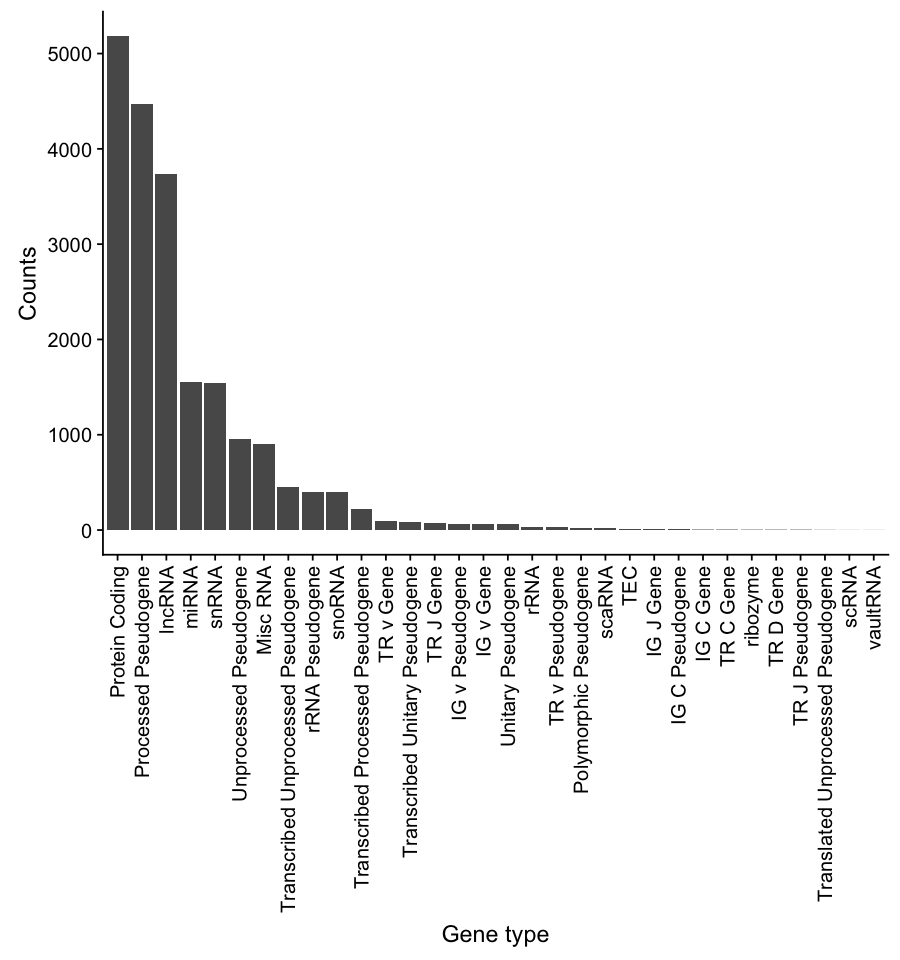

In [5]:
options(repr.plot.width=7.5, repr.plot.height=8)
sf2
ggsave('figures/sfigure_2.pdf', sf2, width=7, height=6)